# Task 4: Autoencoder
Dmytro Geleshko

## Imports

In [146]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn import metrics

## TF Config

In [147]:
tf.test.is_built_with_cuda()

True

In [148]:
tf.config.list_physical_devices("GPU")

[]

## Data
### Loading

In [149]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("Train X:", X_train.shape, X_train.dtype)
print("Train y:", y_train.shape, y_train.dtype)
print("Test X:", X_test.shape, X_test.dtype)
print("Test y:", y_test.shape, y_test.dtype)

Train X: (60000, 28, 28) uint8
Train y: (60000,) uint8
Test X: (10000, 28, 28) uint8
Test y: (10000,) uint8


### Preview

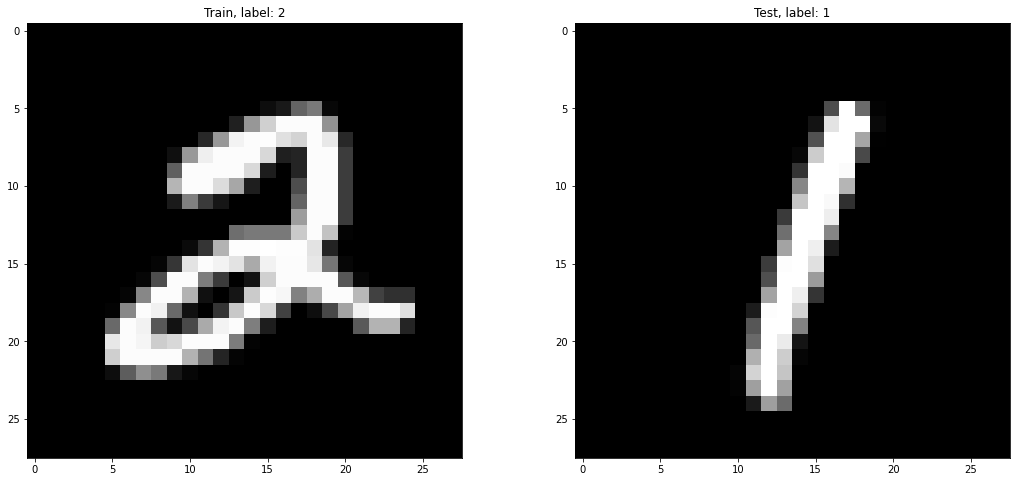

In [150]:
example = 5
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 2, 1)
plt.imshow(X_train[example], "gray")
plt.title("Train, label: " + str(y_train[example]))

plt.subplot(1, 2, 2)
plt.imshow(X_test[example], "gray")
plt.title("Test, label: " + str(y_test[example]))

plt.show()

### Reshape and Cast

In [151]:
X_train = (X_train.reshape(-1, 28 * 28) / 255).astype(np.float32)
X_test = (X_test.reshape(-1, 28 * 28) / 255).astype(np.float32)


print("Train X:", X_train.shape, X_train.dtype)
print("Test X:", X_test.shape, X_test.dtype)

Train X: (60000, 784) float32
Test X: (10000, 784) float32


### Introducing noise

In [152]:
noise_mean = 0
noise_std = 0.2

X_train_noise = np.clip(X_train + np.random.normal(noise_mean, noise_std, size=X_train.shape),
    a_min=0, a_max=1, dtype=np.float32)
X_test_noise = np.clip(X_test + np.random.normal(noise_mean, noise_std, size=X_test.shape),
    a_min=0, a_max=1, dtype=np.float32)

### Preview

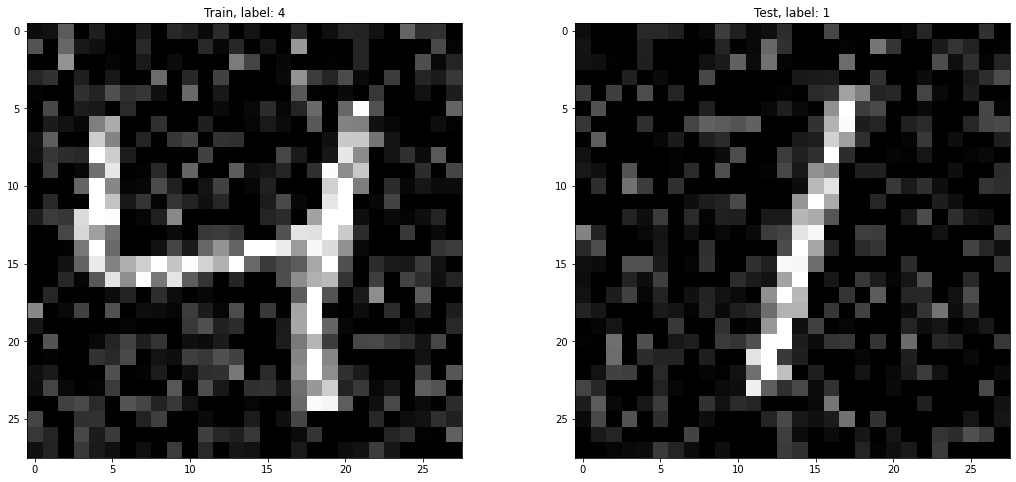

In [153]:
example = 2
plt.rcParams["figure.figsize"] = (18, 8)

plt.subplot(1, 2, 1)
plt.imshow(X_train_noise[example].reshape(28, 28), "gray")
plt.title("Train, label: " + str(y_train[example]))

plt.subplot(1, 2, 2)
plt.imshow(X_test_noise[example].reshape(28, 28), "gray")
plt.title("Test, label: " + str(y_test[example]))

plt.show()

## Autoencoder
### Architecture

In [154]:
def build_autoencoder(input_shape, hidden, code):
    X_in = keras.Input(input_shape)

    X = layers.Dense(hidden, activation="relu")(X_in)

    X = layers.Dense(code, activation="relu")(X)

    X = layers.Dense(hidden, activation="relu")(X)

    X = layers.Dense(input_shape, activation="sigmoid")(X)
    
    return keras.Model(inputs=X_in, outputs=X)

In [155]:
autoencoder = build_autoencoder(784, 128, 32)
print(autoencoder.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_32 (Dense)            (None, 128)               100480    
                                                                 
 dense_33 (Dense)            (None, 32)                4128      
                                                                 
 dense_34 (Dense)            (None, 128)               4224      
                                                                 
 dense_35 (Dense)            (None, 784)               101136    
                                                                 
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________
None


In [156]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy()
)

### Train

In [157]:
autoencoder_history = autoencoder.fit(X_train_noise, X_train, batch_size=32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2365
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1536
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1348
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1259
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1202


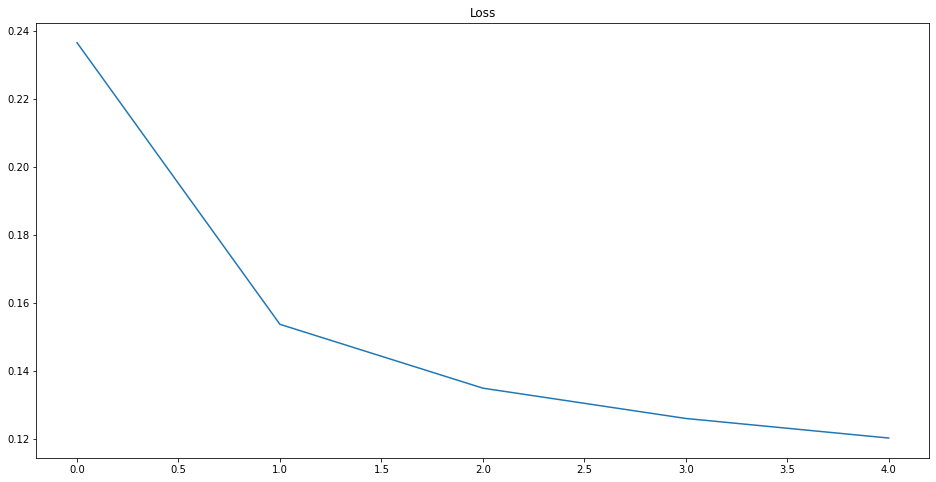

In [158]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(autoencoder_history.history["loss"])
plt.title("Loss")

plt.show()

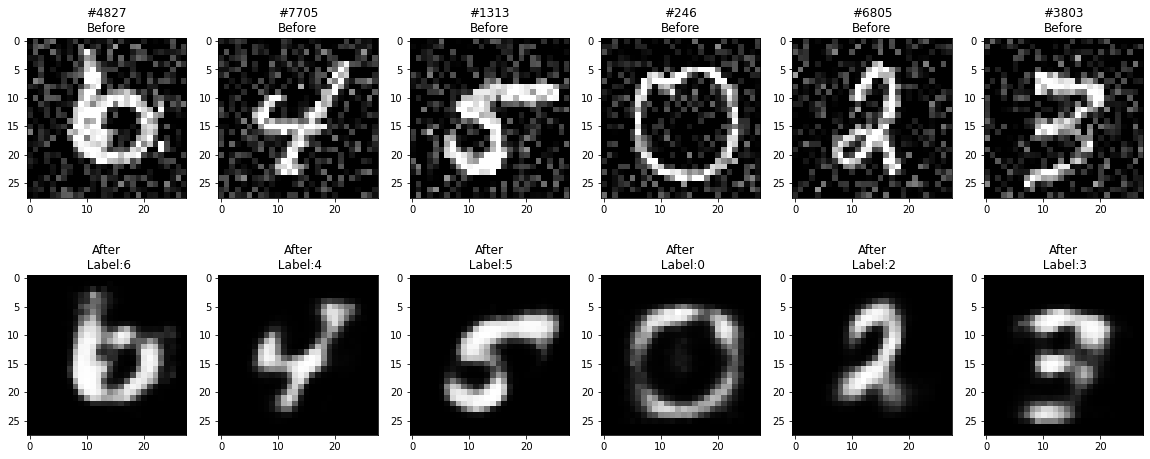

In [159]:
plt.rcParams["figure.figsize"] = (20, 8)
for i in range(6):
    random_example = np.random.randint(0, X_test_noise.shape[0])
    
    plt.subplot(2, 6, i + 1)
    plt.imshow(X_train_noise[random_example].reshape(28, 28), "gray")
    plt.title("#" + str(random_example) + "\nBefore")

    plt.subplot(2, 6, i + 7)
    plt.imshow(autoencoder.predict(X_train_noise[random_example].reshape(1, 784)).reshape(28, 28), "gray")
    plt.title("After\n Label:" + str(y_train[random_example]))

### Denoised data

In [166]:
X_test_denoised = autoencoder.predict(X_test_noise)

## Model

### Architecture

In [160]:
def build_model(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Dense(256, activation="relu")(X_in)

    X = layers.Dense(128, activation="relu")(X)

    X = layers.Dense(64, activation="relu")(X)

    X = layers.Dense(n_classes, activation="softmax")(X)
    
    return keras.Model(inputs=X_in, outputs=X)

In [161]:
model = build_model(784, 10)
print(model.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_36 (Dense)            (None, 256)               200960    
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 10)                650       
                                                                 
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________
None


In [162]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

### Train

In [163]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.05, validation_batch_size=32)

Epoch 1/10
1782/1782 [==============================] - 4s 2ms/step - loss: 0.4728 - sparse_categorical_accuracy: 0.8721 - val_loss: 0.1612 - val_sparse_categorical_accuracy: 0.9577
Epoch 2/10
1782/1782 [==============================] - 4s 2ms/step - loss: 0.1850 - sparse_categorical_accuracy: 0.9466 - val_loss: 0.1135 - val_sparse_categorical_accuracy: 0.9693
Epoch 3/10
1782/1782 [==============================] - 3s 2ms/step - loss: 0.1359 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.0971 - val_sparse_categorical_accuracy: 0.9717
Epoch 4/10
1782/1782 [==============================] - 4s 2ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.0884 - val_sparse_categorical_accuracy: 0.9773
Epoch 5/10
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.0785 - val_sparse_categorical_accuracy: 0.9803
Epoch 6/10
1782/1782 [==============================] - 4s 2ms/step - loss: 0.0723 - spars

In [164]:
def build_model(input_shape, n_classes):
    X_in = keras.Input(input_shape)

    X = layers.Dense(256, activation="relu")(X_in)

    X = layers.Dense(128, activation="relu")(X)

    X = layers.Dense(64, activation="relu")(X)

    X = layers.Dense(n_classes, activation="softmax")(X)
    
    return keras.Model(inputs=X_in, outputs=X)

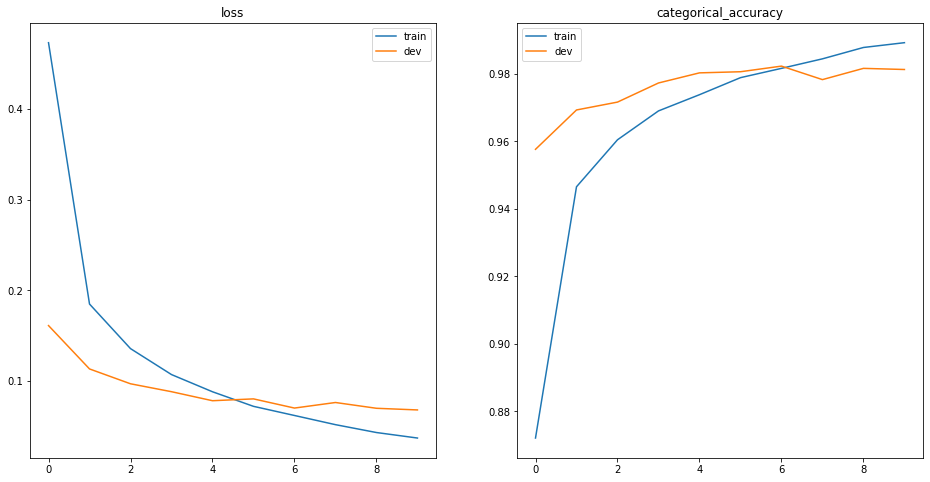

In [165]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="dev")
plt.legend()
plt.title("loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["sparse_categorical_accuracy"], label="train")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="dev")
plt.legend()
plt.title("categorical_accuracy")

plt.show()

## Comparing

In [171]:
print("Standart:", model.evaluate(X_test, y_test, verbose=0))
print("Noisy:", model.evaluate(X_test_noise, y_test, verbose=0))
print("Denoised:", model.evaluate(X_test_denoised, y_test, verbose=0))

Standart: [0.07596012204885483, 0.9771999716758728]
Noisy: [0.3819040358066559, 0.883899986743927]
Denoised: [0.19965916872024536, 0.9412000179290771]
